# Descubra as melhores notas de matemática do ENEM 2016

Você deverá criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016. 

## Tópicos

Neste desafio você aprenderá:

- Lógica
- Análise de dados
- Estatística
- Regression

## Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Muitas universidades brasileiras utilizam o ENEM para selecionar seus futuros alunos e alunas. Isto é feito com uma média ponderada das notas das provas de matemática, ciências da natureza, linguagens e códigos, ciências humanas e redação. Determine os 20 melhores colocados, por ordem, para os pesos abaixo:

- matemática: 3
- ciências da natureza: 2
- linguagens e códigos: 1.5
- ciências humanas: 1
- redação: 3

No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna **NU_NOTA_MT**) de quem participou do ENEM 2016. 

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO** e **NU_NOTA_MT**.

Faça o upload do arquivo answer.csv usando o botão "Submeter resposta".

## Observações

O objetivo do desafio é avaliar a sua capacidade de resolver problemas, então ele pode ser resolvido em qualquer linguagem de programação ou ferramenta que você tenha facilidade. Mas recomendamos o uso de linguagens com maior ferramental de matemática e estatística como Python, R, Scala ou Julia.

# Imports e carga de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.neural_network import MLPRegressor

## Antes de começar, vamos verificar se as colunas são iguais para os dados de treino e teste

In [2]:
dados = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

print('Treino: {}\nTeste: {}'.format(dados.shape, teste.shape))

Treino: (13730, 167)
Teste: (4576, 47)


In [3]:
dados.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [4]:
teste.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

---

A quantidade de colunas nos dados de teste é muito inferior as de treino, por isso serão descartados as colunas que não estão nos dados de teste

In [5]:
dados = dados[teste.columns]

# colunas que não estão nos dados de teste mas que serão usadas na análise
dados['TP_PRESENCA_MT'] = pd.read_csv('train.csv', usecols=['TP_PRESENCA_MT'])

dados['TARGET'] = pd.read_csv('train.csv', usecols=['NU_NOTA_MT'])

---

Com isso já podemos conktinuar com as análises, por enquanto serão usados os dados de treino para a criação dos modelos e definições de pré-processamento.  
Os dados de teste serão usados posteriormente para a geração das previsões para a competição.

# Análise Exploratória.
Com ela podemos compreender melhor os dados para poder tomar decisões sobre passos seguintes.

In [6]:
dados.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,TP_PRESENCA_MT,TARGET
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,D,D,C,A,A,C,H,A,1,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,A,A,B,A,A,A,NaN,A,1,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,D,D,C,A,A,A,NaN,A,0,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,H,E,E,C,B,C,F,D,0,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,E,D,C,A,A,B,F,A,0,NaN


In [7]:
dados.shape

(13730, 49)

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NU_INSCRICAO            13730 non-null  object 
 1   CO_UF_RESIDENCIA        13730 non-null  int64  
 2   SG_UF_RESIDENCIA        13730 non-null  object 
 3   NU_IDADE                13730 non-null  int64  
 4   TP_SEXO                 13730 non-null  object 
 5   TP_COR_RACA             13730 non-null  int64  
 6   TP_NACIONALIDADE        13730 non-null  int64  
 7   TP_ST_CONCLUSAO         13730 non-null  int64  
 8   TP_ANO_CONCLUIU         13730 non-null  int64  
 9   TP_ESCOLA               13730 non-null  int64  
 10  TP_ENSINO               4282 non-null   float64
 11  IN_TREINEIRO            13730 non-null  int64  
 12  TP_DEPENDENCIA_ADM_ESC  4282 non-null   float64
 13  IN_BAIXA_VISAO          13730 non-null  int64  
 14  IN_CEGUEIRA             13730 non-null

In [9]:
# Visão um pouco mais detalhada
print('INFORMAÇÕES SOBRE OS DADOS:\n')
for ind, i in enumerate(dados.columns):
    print('{}\t{}\tTipo: {}\tInválidos: {}\tÚnicos: {}'.format(ind,i,dados[i].dtype,dados[i].isnull().sum(),dados[i].nunique()))
    print('-' * 100)

INFORMAÇÕES SOBRE OS DADOS:

0	NU_INSCRICAO	Tipo: object	Inválidos: 0	Únicos: 13730
----------------------------------------------------------------------------------------------------
1	CO_UF_RESIDENCIA	Tipo: int64	Inválidos: 0	Únicos: 27
----------------------------------------------------------------------------------------------------
2	SG_UF_RESIDENCIA	Tipo: object	Inválidos: 0	Únicos: 27
----------------------------------------------------------------------------------------------------
3	NU_IDADE	Tipo: int64	Inválidos: 0	Únicos: 55
----------------------------------------------------------------------------------------------------
4	TP_SEXO	Tipo: object	Inválidos: 0	Únicos: 2
----------------------------------------------------------------------------------------------------
5	TP_COR_RACA	Tipo: int64	Inválidos: 0	Únicos: 6
----------------------------------------------------------------------------------------------------
6	TP_NACIONALIDADE	Tipo: int64	Inválidos: 0	Únicos: 5
---

---

Análise preliminar e levantamento de hipóteses sobre os dados:

- Colunas CO_UF_RESIDENCIA e SG_UF_RESIDENCIA posuem a mesma informação, mas com tipos diferentes de entradas.
- Colunas TP_ENSINO e TP_DEPENDENCIA_ADM_ESC possuem a mesma quantidade de valores inválidos, o que pode representar algum tipo de falha na captação das amostras dos dados por se tratar de dados referentes a escola e a quantidade de dados faltantes ser significativa (68,88%).
- Colunas TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC representam a presença em cada tipo de prova, e elas combinadas com as colunas de notas talvez possam explicar alguns dos valores faltantes dos mesmos.
- Colunas CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_MT, CO_PROVA_LC, representam os diferentes tipos provas aplicadas, e para este tipo de análise estas informações talvez não sejam muito relevantes.
- Colunas NU_NOTA_COMP1 a NU_NOTA_COMP5 e TP_STATUS_REDACAO	definem o porque do candidato receber a nota final da redação.
- Colunas Q001, Q002, Q006, Q024, Q025, Q026, Q027 e Q047 pertencem ao questionário socio-econômico respondido pelo candidato, e possui informações sobre a escolaridade dos pais, se possui acesso a um computador e internet em casa e dados sobre trabalho e escola dos candidatos.

---

Antes de iniciar o pre-processamento, vamos separar em dados categoricos e numericos para facilitar as transformações e confirmar algumas hipóteses

In [10]:
# Separa em dados categóricos e numéricos para facilitar as análises
categoricos = dados[[i for i in dados.columns if(dados[i].dtype == 'object')]]
numericos = dados[[i for i in dados.columns if(dados[i].dtype != 'object')]]

In [11]:
# valores nulos dos dados categóricos
categoricos.isnull().sum()

NU_INSCRICAO           0
SG_UF_RESIDENCIA       0
TP_SEXO                0
CO_PROVA_CN            0
CO_PROVA_CH            0
CO_PROVA_LC            0
CO_PROVA_MT            0
Q001                   0
Q002                   0
Q006                   0
Q024                   0
Q025                   0
Q026                   0
Q027                7373
Q047                   0
dtype: int64

In [12]:
# Quantidade de categorias
categoricos.nunique()

NU_INSCRICAO        13730
SG_UF_RESIDENCIA       27
TP_SEXO                 2
CO_PROVA_CN            10
CO_PROVA_CH            10
CO_PROVA_LC             9
CO_PROVA_MT             9
Q001                    8
Q002                    8
Q006                   17
Q024                    5
Q025                    2
Q026                    3
Q027                   13
Q047                    5
dtype: int64

In [13]:
# valores nulos dos dados numericos
numericos.isnull().sum()

CO_UF_RESIDENCIA             0
NU_IDADE                     0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 9448
IN_TREINEIRO                 0
TP_DEPENDENCIA_ADM_ESC    9448
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_LINGUA                    0
TP_STATUS_REDACAO         3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
TP_PRESE

In [14]:
# Quantidade de categorias dos dados numéricos
numericos.nunique()

CO_UF_RESIDENCIA            27
NU_IDADE                    55
TP_COR_RACA                  6
TP_NACIONALIDADE             5
TP_ST_CONCLUSAO              4
TP_ANO_CONCLUIU             11
TP_ESCOLA                    4
TP_ENSINO                    3
IN_TREINEIRO                 2
TP_DEPENDENCIA_ADM_ESC       4
IN_BAIXA_VISAO               2
IN_CEGUEIRA                  1
IN_SURDEZ                    2
IN_DISLEXIA                  2
IN_DISCALCULIA               2
IN_SABATISTA                 2
IN_GESTANTE                  2
IN_IDOSO                     2
TP_PRESENCA_CN               3
TP_PRESENCA_CH               3
TP_PRESENCA_LC               3
NU_NOTA_CN                2692
NU_NOTA_CH                2978
NU_NOTA_LC                2774
TP_LINGUA                    2
TP_STATUS_REDACAO            9
NU_NOTA_COMP1               15
NU_NOTA_COMP2               13
NU_NOTA_COMP3               12
NU_NOTA_COMP4               14
NU_NOTA_COMP5               14
NU_NOTA_REDACAO             53
TP_PRESE

In [15]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_CH != 1])

3389

In [16]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_CN != 1])

3389

In [17]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_LC != 1])

3597

In [18]:
numericos.corr().iloc[:,-1].sort_values(ascending=False)

TARGET                    1.000000
NU_NOTA_CN                0.584941
NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_REDACAO           0.379376
TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP5             0.343337
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP1             0.299402
CO_UF_RESIDENCIA          0.107493
TP_ESCOLA                 0.069304
TP_ANO_CONCLUIU           0.029039
IN_DISCALCULIA            0.009813
TP_PRESENCA_CH            0.003552
TP_PRESENCA_CN            0.003552
IN_DISLEXIA               0.001453
IN_BAIXA_VISAO            0.000685
IN_GESTANTE              -0.000945
IN_IDOSO                 -0.011336
IN_SURDEZ                -0.015249
IN_SABATISTA             -0.016459
IN_TREINEIRO             -0.022287
TP_NACIONALIDADE         -0.034965
TP_STATUS_REDACAO        -0.059376
NU_IDADE                 -0.061485
TP_ENSINO                -0.086353
TP_ST_CONCLUSAO     

In [19]:
numericos.columns

Index(['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'TP_PRESENCA_MT', 'TARGET'],
      dtype='object')

---

- Para que não seja perdida nenhum tipo de informação podemos criar novas categorias que irão representar os dados inválidos de algumas variáveis.
- A hipótese de que os dados inválidos das colunas de notas correspodem realmente com os mesmos candidatos que faltaram ou tiveram a prova cancelada por algum motivo.
- Tambem foi verificado quais variáveis possuem maior correlação com a variável alvo das predições, mesmo que um nível alto de correlação não implique necessáriamente causalidade, seu valor pode ser um indicativo da importancia dessa variável.

# Pré - processamento
Nesta etapa serão transformados e tratados os dados, afim de diminuir suas inconsistências e tornar o processo de definição das variáveis do modelo (**feature selection**) mais fácil e precisa.

## Pré - processamento: Tratamento de Valores inválidos - Variáveis categóricas
Algo que pode ser feito é a criação de uma nova categoria para a coluna Q027 que receberá os valores inválidos.  
Como ela possui 13 categorias, representadas pelas letras A até M, a nova categoria que representará os dados não definidos será a letra **N**.

In [20]:
categoricos.fillna('N', inplace=True)

C:\Users\alber\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Pré - processamento: Tratamento de Valores inválidos  - Variáveis numéricas


As variáveis possuem dois tipos de casos específicos em seus valores inválidos:

- Os valores inválidos das colunas de notas corresponde ao cruzamento dos dados dos alunos que faltaram na prova ou tiveram a mesma cancelada, o que podemos concluir que faz sentido atribuir o valor 0 (zero) para elas.


- As colunas TP_ENSINO e TP_DEPENDENCIA_ADM_ESC não possuem motivos aparentes para o surgimento dos valores inválidos, o fato de serem informações referentes a escola e por possuirem a mesma quantidade de valores inválidos podem ser indicadores que ocorreram erros na coleta dos dados. Neste caso, para que não seja desperdiçada as informações, será criada uma nova categoria para cada variável que representará os valores inválidos: TP_ENSINO receberá a categoria **4** - Indefinido e a TP_DEPENDENCIA_ADM_ESC a categoria **5** - Indefinido.


- A variável alvo (nota de matemática) possui os valores inválidos equivalentes aos alunos que não fizeram a prova, com uma diferença: o arquivo disponibilizado para que seja feita as previsões finais da competição **não** possui a coluna que define se o aluno estava presente na realização da prova, o que nos faz partir do pressuposto que todos os alunos presentes no conjunto de teste estavam presentes na prova. Por isso, para o treinamento dos modelos serão usados apenas os dados válidos (aluno presente e que não teve a prova anulada) para o treinamento.

In [21]:
#Cria as novas categorias
numericos['TP_ENSINO'].fillna(4,inplace=True)
numericos['TP_DEPENDENCIA_ADM_ESC'].fillna(5,inplace=True)
numericos['TP_STATUS_REDACAO'].fillna(10, inplace=True)


C:\Users\alber\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [22]:
numericos.columns[:-2]

Index(['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO'],
      dtype='object')

In [23]:
# seta os valores 0 das notas
numericos.fillna(0,inplace=True)


---

Com isso eliminamos os valores inválidos.  
O próximo passo é diminuir a quantidade de categorias para a criação das variávies dummies

## Pré - processamento: Diminuição de dimensionalidade
Podemos diminuir as colunas TP_PRESENCA_LC, TP_PRESENCA_CH, TP_PRESENCA_CN para apenas 2:
- 0 - Faltou a prova
- 1 - Presente

A coluna TP_PRESENCA_MT não precisará ser modificada pois ela será retirada mais a frente

In [24]:
# Diminuir as categorias
for i in ['TP_PRESENCA_LC', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN']:
    numericos[i] = np.where(numericos[i] != 1, 0, 1)
    teste[i] = np.where(teste[i] != 1, 0, 1)

C:\Users\alber\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# podemos verificar novamente os valores de correlação para saber se os valores foram alterados depois das transformações
numericos.corr().iloc[:,-1].sort_values(ascending=False)

TARGET                    1.000000
NU_NOTA_LC                0.943954
TP_PRESENCA_LC            0.927129
TP_PRESENCA_MT            0.923641
NU_NOTA_CN                0.907039
NU_NOTA_CH                0.903608
NU_NOTA_COMP1             0.882746
TP_PRESENCA_CH            0.879128
TP_PRESENCA_CN            0.879128
NU_NOTA_REDACAO           0.875929
NU_NOTA_COMP4             0.866827
NU_NOTA_COMP2             0.862709
NU_NOTA_COMP3             0.854946
NU_NOTA_COMP5             0.722275
TP_ESCOLA                 0.189084
IN_TREINEIRO              0.078804
TP_ST_CONCLUSAO           0.023736
IN_DISCALCULIA            0.008392
IN_DISLEXIA               0.005259
CO_UF_RESIDENCIA          0.002613
IN_SABATISTA             -0.002457
IN_SURDEZ                -0.002617
IN_BAIXA_VISAO           -0.006546
IN_IDOSO                 -0.009061
IN_GESTANTE              -0.028129
TP_NACIONALIDADE         -0.033130
TP_COR_RACA              -0.070239
TP_DEPENDENCIA_ADM_ESC   -0.109590
TP_LINGUA           

---

Com isso podemos ver algumas coisas interessantes:
- As notas das provas continuam sendo as variáveis com as maiores correlações positivas.
- É possivel ver outras variáveis com seus respectivos valores de correlação que antes não apareciam, como é o caso da TP_STATUS_REDACAO.

## Pré - processamento: Reorganizando os dados em um dataframe único novamente

In [26]:
# Separar em alunos que estavam presentes nas provas de matematica
dados = pd.concat((categoricos,numericos), axis=1)

# Dados de alunos que fizeram a prova de matematica
#dados = dados[dados.TP_PRESENCA_MT == 1]

# Retirar a coluna que não será usada
dados.drop('TP_PRESENCA_MT', inplace=True, axis=1)

# Caso 23 
## Obs: este é um notebook com o modelo já selecionado, por isso a marcação 23 (Testes anteriores incluiram features e algoritmos diferentes): 


- **Feature Selection**: NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC, NU_NOTA_REDACAO, NU_PONDERADA.  
- **Tratamento para variáveis numéricas**: Escalonamento.  
- **Algoritmos usados**: Redes neurais
- **Métricas de Avaliação**: MAE, MSE, RMSE


In [29]:
# pega os labels correspondentes, excluindo a inscrição
label_numericos = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC', 'NU_NOTA_REDACAO']

# Criação do dataframe de caso de teste 13
c23 = dados[label_numericos]


# Função para aplicar a média ponderada
def media(col):
    ponderada = ((col[0] * 2) + col[1] + (col[2] * 1.5) + (col[3] * 3)) / 7.5
    
    return ponderada

c23['NU_PONDERADA'] = c23.apply(media, axis=1)




# Escalonamento
scaler_x = StandardScaler()

c23 = scaler_x.fit_transform(c23.values) 

scaler_y = StandardScaler()

y = dados.TARGET

y = y.values

y = scaler_y.fit_transform(y.reshape(-1,1))

y = y.ravel()

C:\Users\alber\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
x_train, x_test,y_train, y_test = train_test_split(c23, y, test_size=0.2)


## MLPRegressor

In [31]:
# modelo sem ajustes
mlp_model = MLPRegressor(hidden_layer_sizes=(77),   
                         verbose=True,
                         max_iter=1000,
                         tol=0.000001,)
mlp_model.fit(x_train, y_train)
mlp_predict = mlp_model.predict(x_test)
#plt.scatter(y_test, mlp_predict)

mlp_model.score(x_train, y_train)

Iteration 1, loss = 0.06959808
Iteration 2, loss = 0.04155524
Iteration 3, loss = 0.04014294
Iteration 4, loss = 0.03940875
Iteration 5, loss = 0.03914821
Iteration 6, loss = 0.03929728
Iteration 7, loss = 0.03864834
Iteration 8, loss = 0.03863347
Iteration 9, loss = 0.03865044
Iteration 10, loss = 0.03857154
Iteration 11, loss = 0.03856064
Iteration 12, loss = 0.03864195
Iteration 13, loss = 0.03861805
Iteration 14, loss = 0.03834635
Iteration 15, loss = 0.03839658
Iteration 16, loss = 0.03863653
Iteration 17, loss = 0.03841582
Iteration 18, loss = 0.03842249
Iteration 19, loss = 0.03851979
Iteration 20, loss = 0.03868538
Iteration 21, loss = 0.03846421
Iteration 22, loss = 0.03868086
Iteration 23, loss = 0.03837883
Iteration 24, loss = 0.03827090
Iteration 25, loss = 0.03839220
Iteration 26, loss = 0.03820019
Iteration 27, loss = 0.03840664
Iteration 28, loss = 0.03848963
Iteration 29, loss = 0.03825186
Iteration 30, loss = 0.03846089
Iteration 31, loss = 0.03830902
Iteration 32, los

0.9232292653316262

In [32]:
mlp_model.score(x_test, y_test)

0.9201883094813579

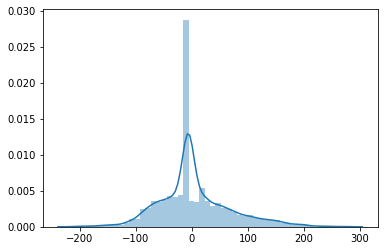

In [33]:
sns.distplot(scaler_y.inverse_transform(y_test) - scaler_y.inverse_transform(mlp_predict))

In [34]:
# métricas
print('MAE: {}\nMSE: {}\nRMSE: {}'.format(
    mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict)),
    mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict)),
    np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict)))))

MAE: 45.96293109013058
MSE: 4196.998546754842
RMSE: 64.78424613094485


# Arquivo: pré-processamento

In [37]:
c23_test = pd.read_csv('test.csv')
c23_test = c23_test[label_numericos]
# seta os valores 0 das notas
c23_test.fillna(-20,inplace=True)

c23_test['NU_NOTA_PONDERADA'] = c23_test.apply(media, axis=1)

c23_test = scaler_x.transform(c23_test.values)

In [38]:
resposta = pd.read_csv('test.csv', usecols=['NU_INSCRICAO'])

# GERA O RESULTADO COM mlp
previsao = mlp_model.predict(c23_test)
resposta['NU_NOTA_MT'] = scaler_y.inverse_transform(previsao)
resposta.to_csv('answer.csv', index=False)
